In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import PIL.Image as Image
# i prefer PIL to draw the text, more beautiful
import PIL.ImageDraw as ImageDraw
import PIL.ImageFont as ImageFont
import numpy.polynomial.polynomial as poly
from scipy import signal

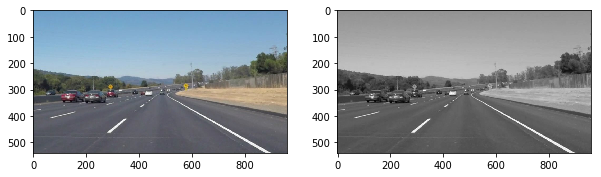

In [2]:
image = cv2.imread('straight-lane.jpg')
plt.figure(figsize = (10, 10))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY),cmap='gray')
plt.show()

In [3]:
import math

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    mask = np.zeros_like(img)   
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255   
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def select_rgb_white_yellow(image): 
    # white color mask
    lower = np.uint8([200, 200, 200])
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(image, lower, upper)
    # yellow color mask
    lower = np.uint8([190, 190,   0])
    upper = np.uint8([255, 255, 255])
    yellow_mask = cv2.inRange(image, lower, upper)
    # combine the mask
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked = cv2.bitwise_and(image, image, mask = mask)
    return masked

In [4]:
rows, cols   = image.shape[:2]
bottom_left  = [int(cols*0.02), int(rows*1)]
top_left     = [int(cols*0.35), int(rows*0.65)]
bottom_right = [int(cols*0.98), int(rows*1)]
top_right    = [int(cols*0.65), int(rows*0.65)]

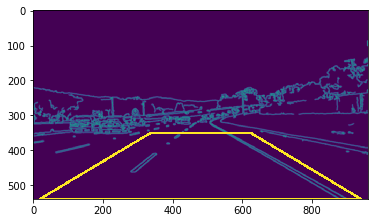

In [5]:
gaussian_7 = gaussian_blur(canny(image, 50, 150),7)
copied = np.copy(gaussian_7)
cv2.line(copied, tuple(bottom_left), tuple(bottom_right), (255,0,0), 5)
cv2.line(copied, tuple(bottom_left), tuple(top_left), (255,0,0), 5)
cv2.line(copied, tuple(top_left), tuple(top_right), (255,0,0), 5)
cv2.line(copied, tuple(top_right), tuple(bottom_right), (255,0,0), 5)
plt.imshow(copied)
plt.show()

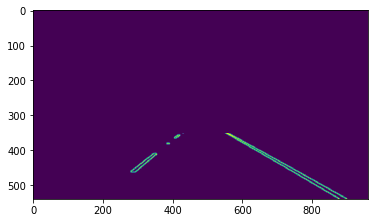

In [6]:
copied = np.copy(gaussian_7)
vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
interested = region_of_interest(copied, vertices)
plt.imshow(interested)
plt.show()

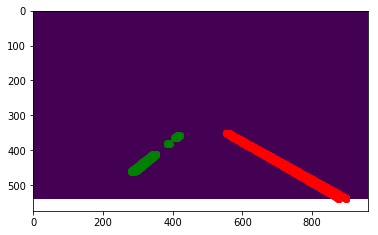

In [7]:
wheres_left = np.where(interested[:,:image.shape[1]//2] > 80)
wheres_right = np.where(interested[:,image.shape[1]//2:] > 80)
plt.imshow(interested)
plt.scatter(wheres_left[1],wheres_left[0],color='g')
plt.scatter(image.shape[1]//2+wheres_right[1],wheres_right[0],color='r')
plt.show()

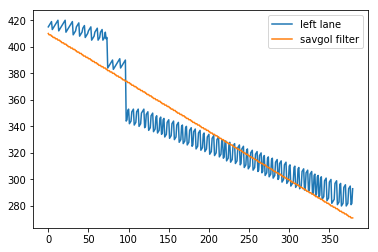

CPU times: user 128 ms, sys: 200 ms, total: 328 ms
Wall time: 109 ms


In [8]:
%%time
plt.plot(wheres_left[1],label='left lane')
savgol = signal.savgol_filter(wheres_left[1], wheres_left[1].shape[0]-1, 1)
plt.plot(savgol.astype('int'),label='savgol filter')
plt.legend()
plt.show()

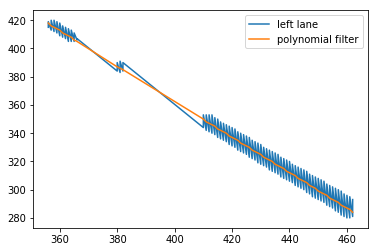

CPU times: user 128 ms, sys: 188 ms, total: 316 ms
Wall time: 105 ms


In [9]:
%%time
coefs_left = poly.polyfit(wheres_left[0], wheres_left[1], 1)
ffit_left = poly.polyval(wheres_left[0], coefs_left)
plt.plot(wheres_left[0], wheres_left[1],label='left lane')
plt.plot(wheres_left[0], ffit_left.astype('int'),label='polynomial filter')
plt.legend()
plt.show()

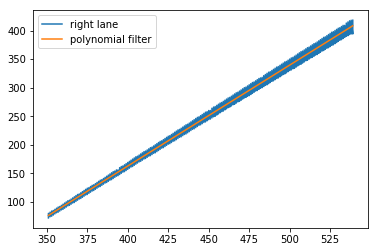

In [10]:
coefs_right = poly.polyfit(wheres_right[0], wheres_right[1], 1)
ffit_right = poly.polyval(wheres_right[0], coefs_right)
plt.plot(wheres_right[0], wheres_right[1],label='right lane')
plt.plot(wheres_right[0], ffit_right,label='polynomial filter')
plt.legend()
plt.show()

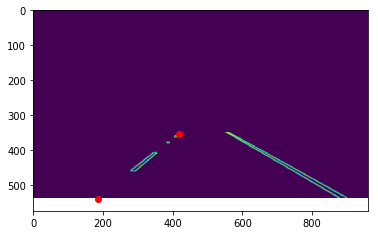

In [11]:
top_left = [np.max(ffit_left),np.min(wheres_left[0])]
bottom_left = [np.min(ffit_left),np.max(wheres_left[0])]
m_left, c_left = np.polyfit([bottom_left[1],top_left[1]],
                           [bottom_left[0],top_left[0]],1)
bottom_left = [int(image.shape[0]*m_left+c_left),image.shape[0]]
plt.imshow(interested)
plt.scatter(np.max(ffit_left),np.min(wheres_left[0]),color='r')
plt.scatter(int(image.shape[0]*m_left+c_left),image.shape[0],color='r')
plt.show()

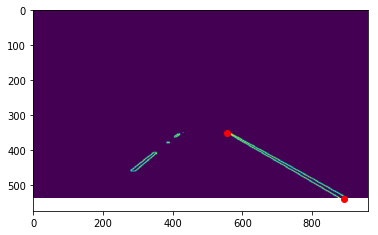

In [12]:
top_right = [image.shape[1]//2+np.min(ffit_right),np.min(wheres_right[0])]
bottom_right = [image.shape[1]//2+np.max(ffit_right),np.max(wheres_right[0])]
m_right, c_right = np.polyfit([bottom_right[1],top_right[1]],
                           [bottom_right[0],top_right[0]],1)
bottom_right = [int(image.shape[0]*m_right+c_right),image.shape[0]]
plt.imshow(interested)
plt.scatter(image.shape[1]//2+np.min(ffit_right),np.min(wheres_right[0]),color='r')
plt.scatter(int(image.shape[0]*m_right+c_right),image.shape[0],color='r')
plt.show()

In [13]:
from moviepy.editor import VideoFileClip

In [14]:
def process_image(image):
    gray = grayscale(image)
    low_threshold = 100
    high_threshold = 150
    edges = canny(gray, low_threshold, high_threshold)
    kernel_size = 7
    blur_gray = gaussian_blur(edges,kernel_size)
    mask = np.zeros_like(edges)   
    ignore_mask_color = 255
    rows, cols   = image.shape[:2]
    bottom_left  = [int(cols*0.02), int(rows*1)]
    top_left     = [int(cols*0.35), int(rows*0.65)]
    bottom_right = [int(cols*0.98), int(rows*1)]
    top_right    = [int(cols*0.65), int(rows*0.65)]
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    interested = region_of_interest(edges, vertices)
    wheres_left = np.where(interested[:,:image.shape[1]//2] > 80)
    wheres_right = np.where(interested[:,image.shape[1]//2:] > 80)
    
    without_stack = np.stack((np.copy(interested),)*3, -1)
    for i in range(wheres_left[0].shape[0]):
        cv2.circle(without_stack,(wheres_left[1][i],wheres_left[0][i]),5,(255, 0, 0), 3)
    for i in range(wheres_right[0].shape[0]):
        cv2.circle(without_stack,(image.shape[1]//2+wheres_right[1][i],wheres_right[0][i]),5,(255, 0, 0), 3)
        
    pil_image = Image.fromarray(np.uint8(without_stack))
    draw = ImageDraw.Draw(pil_image)
    font = ImageFont.truetype('Roboto-Regular.ttf', 40)
    draw.text((10, 60),'without smoothing',fill='white',font=font)
    without_stack = np.array(pil_image)
        
    coefs_left = poly.polyfit(wheres_left[0], wheres_left[1], 1)
    ffit_left = poly.polyval(wheres_left[0], coefs_left).astype('int')
    coefs_right = poly.polyfit(wheres_right[0], wheres_right[1], 1)
    ffit_right = poly.polyval(wheres_right[0], coefs_right).astype('int')
    
    stack = np.stack((np.copy(interested),)*3, -1)
    for i in range(wheres_left[0].shape[0]):
        cv2.circle(stack,(ffit_left[i],wheres_left[0][i]),5,(255, 0, 0), 3)
    for i in range(wheres_right[0].shape[0]):
        cv2.circle(stack,(image.shape[1]//2+ffit_right[i],wheres_right[0][i]),5,(255, 0, 0), 3)
        
    pil_image = Image.fromarray(np.uint8(stack))
    draw = ImageDraw.Draw(pil_image)
    font = ImageFont.truetype('Roboto-Regular.ttf', 40)
    draw.text((10, 60),'with smoothing',fill='white',font=font)
    stack = np.array(pil_image)
    
    return np.concatenate([without_stack, stack],axis=1)

In [15]:
white_output = 'testwhite_both.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")

white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio = False)

[MoviePy] >>>> Building video testwhite_both.mp4
[MoviePy] Writing video testwhite_both.mp4


100%|█████████▉| 221/222 [00:06<00:00, 33.54it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: testwhite_both.mp4 

CPU times: user 9.74 s, sys: 1.26 s, total: 11 s
Wall time: 6.78 s
